# This Notebook shows the difference between 2 approaches when taking final decision using Cosine similarity vs using MLP Head

# The old inaccurate Age Invariant Face Matching  system (uses Cosine similarity),while the new more accurate uses MLP Head for fina decision if pair of images match or not

# Install facenet library

In [2]:
!pip install facenet_pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 26.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 77.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 76.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 72.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 91.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 33.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 811.4 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.

# Age Invariant Face Matching Pipeline (OLD) using Cosine Similarity for Final Decision

Downloading...
From (original): https://drive.google.com/uc?id=1xyGYBYRQwjBpPreZmvv_enQ3Z92wHNSx
From (redirected): https://drive.google.com/uc?id=1xyGYBYRQwjBpPreZmvv_enQ3Z92wHNSx&confirm=t&uuid=d0b61a99-c7d9-48d0-b0d4-1173e417c7f2
To: /content/resnet50_age_model.keras
100%|██████████| 185M/185M [00:01<00:00, 169MB/s]


✓ All models loaded!


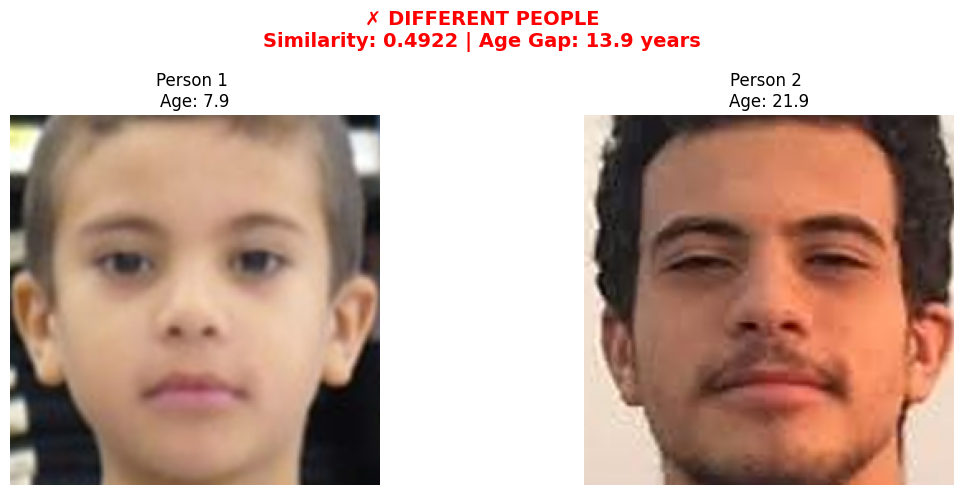


Image 1: Age 7.9
Image 2: Age 21.9
Age Difference: 13.9 years
Similarity Score: 0.4922
Threshold: 0.5
Result: DIFFERENT PEOPLE ✗


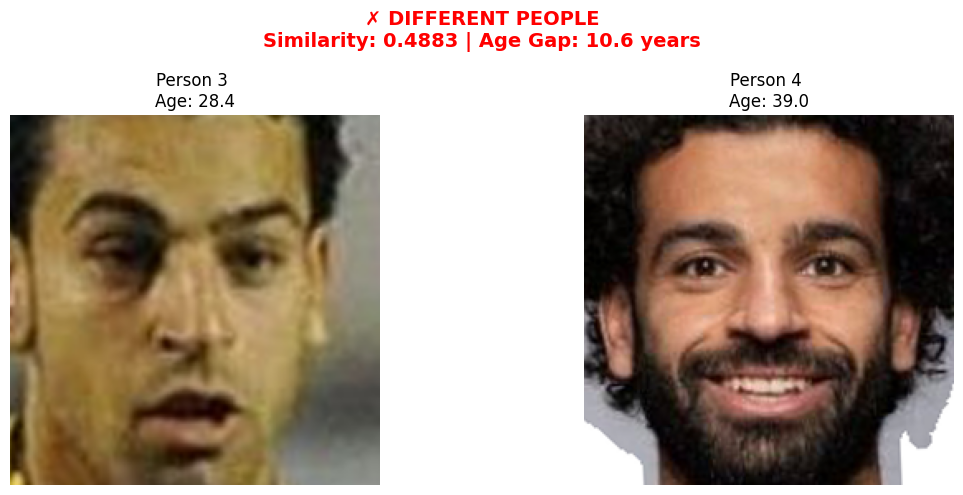


Image 1: Age 28.4
Image 2: Age 39.0
Age Difference: 10.6 years
Similarity Score: 0.4883
Threshold: 0.5
Result: DIFFERENT PEOPLE ✗


In [43]:
import gdown
import tensorflow as tf
from facenet_pytorch import MTCNN, InceptionResnetV1
from PIL import Image
import numpy as np
import cv2
from matplotlib import pyplot as plt
from scipy.spatial.distance import cosine
import torch

# -----------------------------
# 1. Load Models
# -----------------------------
# Age prediction model
file_id = "1xyGYBYRQwjBpPreZmvv_enQ3Z92wHNSx"
download_url = f"https://drive.google.com/uc?id={file_id}"
output_path = "resnet50_age_model.keras"
gdown.download(download_url, output_path, quiet=False)
age_model = tf.keras.models.load_model(output_path)

# Face detection
mtcnn = MTCNN()

# Face matching model
facenet = InceptionResnetV1(pretrained='vggface2').eval()

print("✓ All models loaded!")

# -----------------------------
# 2. Helper Functions
# -----------------------------
def align_face(img_cv, landmark, output_size=(224, 224)):
    """Align face based on eye landmarks"""
    left_eye, right_eye, nose = landmark[0], landmark[1], landmark[2]

    eyes_center = ((left_eye[0] + right_eye[0]) / 2,
                   (left_eye[1] + right_eye[1]) / 2)

    dy, dx = right_eye[1] - left_eye[1], right_eye[0] - left_eye[0]
    angle = np.degrees(np.arctan2(dy, dx))

    desired_eye_distance = output_size[0] * 0.35
    dist = np.sqrt(dx**2 + dy**2)
    scale = desired_eye_distance / dist

    M = cv2.getRotationMatrix2D(eyes_center, angle, scale)
    M[0, 2] += (output_size[0] * 0.5 - eyes_center[0])
    M[1, 2] += (output_size[1] * 0.4 - eyes_center[1])

    aligned_face = cv2.warpAffine(img_cv, M, output_size, flags=cv2.INTER_CUBIC)
    return aligned_face

def preprocess_for_age(face_img):
    """Preprocess for age model (ResNet50)"""
    from tensorflow.keras.applications.resnet50 import preprocess_input
    x = cv2.cvtColor(face_img, cv2.COLOR_BGR2RGB)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

def preprocess_for_facenet(face_img):
    """Preprocess for FaceNet (160x160, normalized)"""
    face_resized = cv2.resize(face_img, (160, 160))
    face_rgb = cv2.cvtColor(face_resized, cv2.COLOR_BGR2RGB)
    face_normalized = (face_rgb - 127.5) / 128.0
    face_tensor = torch.FloatTensor(face_normalized).permute(2, 0, 1).unsqueeze(0)
    return face_tensor

# -----------------------------
# 3. Main Function
# -----------------------------
def match_faces(img_path1, img_path2, threshold=0.6):
    """
    Match two face images

    Args:
        img_path1, img_path2: Paths to images
        threshold: Similarity threshold (default 0.6)

    Returns:
        Dictionary with results
    """
    results = {}

    # Process Image 1
    img1 = Image.open(img_path1).convert('RGB')
    img1_cv = cv2.cvtColor(np.array(img1), cv2.COLOR_RGB2BGR)
    boxes1, probs1, landmarks1 = mtcnn.detect(img1, landmarks=True)

    if boxes1 is None:
        print(f"No face detected in {img_path1}")
        return None

    aligned_face1 = align_face(img1_cv, landmarks1[0], output_size=(224, 224))

    # Age prediction for Image 1
    age_input1 = preprocess_for_age(aligned_face1)
    age1 = age_model.predict(age_input1, verbose=0)[0][0]

    # Face embedding for Image 1
    face_tensor1 = preprocess_for_facenet(aligned_face1)
    with torch.no_grad():
        embedding1 = facenet(face_tensor1).numpy().flatten()

    # Process Image 2
    img2 = Image.open(img_path2).convert('RGB')
    img2_cv = cv2.cvtColor(np.array(img2), cv2.COLOR_RGB2BGR)
    boxes2, probs2, landmarks2 = mtcnn.detect(img2, landmarks=True)

    if boxes2 is None:
        print(f"No face detected in {img_path2}")
        return None

    aligned_face2 = align_face(img2_cv, landmarks2[0], output_size=(224, 224))

    # Age prediction for Image 2
    age_input2 = preprocess_for_age(aligned_face2)
    age2 = age_model.predict(age_input2, verbose=0)[0][0]

    # Face embedding for Image 2
    face_tensor2 = preprocess_for_facenet(aligned_face2)
    with torch.no_grad():
        embedding2 = facenet(face_tensor2).numpy().flatten()

    # Compute similarity
    similarity = 1 - cosine(embedding1, embedding2)
    is_match = similarity >= threshold

    # Store results
    results = {
        'age1': float(age1),
        'age2': float(age2),
        'age_difference': abs(float(age1 - age2)),
        'similarity': float(similarity),
        'is_match': is_match,
        'threshold': threshold,
        'face1': aligned_face1,
        'face2': aligned_face2
    }

    return results

def visualize_results(results, img_name1, img_name2):
    """Display results"""
    if results is None:
        return

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Image 1
    axes[0].imshow(cv2.cvtColor(results['face1'], cv2.COLOR_BGR2RGB))
    axes[0].set_title(f"{img_name1}\nAge: {results['age1']:.1f}", fontsize=12)
    axes[0].axis('off')

    # Image 2
    axes[1].imshow(cv2.cvtColor(results['face2'], cv2.COLOR_BGR2RGB))
    axes[1].set_title(f"{img_name2}\nAge: {results['age2']:.1f}", fontsize=12)
    axes[1].axis('off')

    # Overall result
    match_text = "✓ SAME PERSON" if results['is_match'] else "✗ DIFFERENT PEOPLE"
    color = 'green' if results['is_match'] else 'red'

    fig.suptitle(
        f"{match_text}\n"
        f"Similarity: {results['similarity']:.4f} | "
        f"Age Gap: {results['age_difference']:.1f} years",
        fontsize=14, fontweight='bold', color=color
    )

    plt.tight_layout()
    plt.show()

    # Print details
    print("\n" + "="*50)
    print(f"Image 1: Age {results['age1']:.1f}")
    print(f"Image 2: Age {results['age2']:.1f}")
    print(f"Age Difference: {results['age_difference']:.1f} years")
    print(f"Similarity Score: {results['similarity']:.4f}")
    print(f"Threshold: {results['threshold']}")
    print(f"Result: {'SAME PERSON ✓' if results['is_match'] else 'DIFFERENT PEOPLE ✗'}")
    print("="*50)

# -----------------------------
# 4. Usage Examples
# -----------------------------

img1_path = "/content/test_images/ahmed7years.jpeg"
img2_path = "/content/test_images/ahmedthanwya3ama.jpeg"
img3_path="/content/test_images/mosalah_Arabcontractor.jfif"
img4_path="/content/test_images/Mo-Salah-PNG-Photo.png"
results = match_faces(img1_path, img2_path, threshold=0.5)
visualize_results(results, "Person 1 ", "Person 2 ")
results_v2= match_faces(img3_path, img4_path, threshold=0.5)
visualize_results(results_v2, "Person 3 ", "Person 4 ")

# Final Age invariant Face Matching System using MLP head for final decision

# Load MLP model

In [18]:
import gdown

# Google Drive file ID
file_id = "1dBW7oiQ20AuKKb3uhCfbRh_TElWyel9U"

# Output file name (same as on Drive)
output_name = "face_verification_mlp.keras"

# Download the file
gdown.download(f"https://drive.google.com/uc?id={file_id}", output_name, quiet=False)

print(f"✅ Model downloaded and saved as '{output_name}'")


Downloading...
From: https://drive.google.com/uc?id=1dBW7oiQ20AuKKb3uhCfbRh_TElWyel9U
To: /content/face_verification_mlp.keras
100%|██████████| 10.3M/10.3M [00:00<00:00, 32.6MB/s]

✅ Model downloaded and saved as 'face_verification_mlp.keras'


Downloading...
From (original): https://drive.google.com/uc?id=1xyGYBYRQwjBpPreZmvv_enQ3Z92wHNSx
From (redirected): https://drive.google.com/uc?id=1xyGYBYRQwjBpPreZmvv_enQ3Z92wHNSx&confirm=t&uuid=6167c569-e2ef-4516-9b85-17d73ce744e6
To: /content/resnet50_age_model.keras
100%|██████████| 185M/185M [00:01<00:00, 120MB/s]


✓ All models loaded!


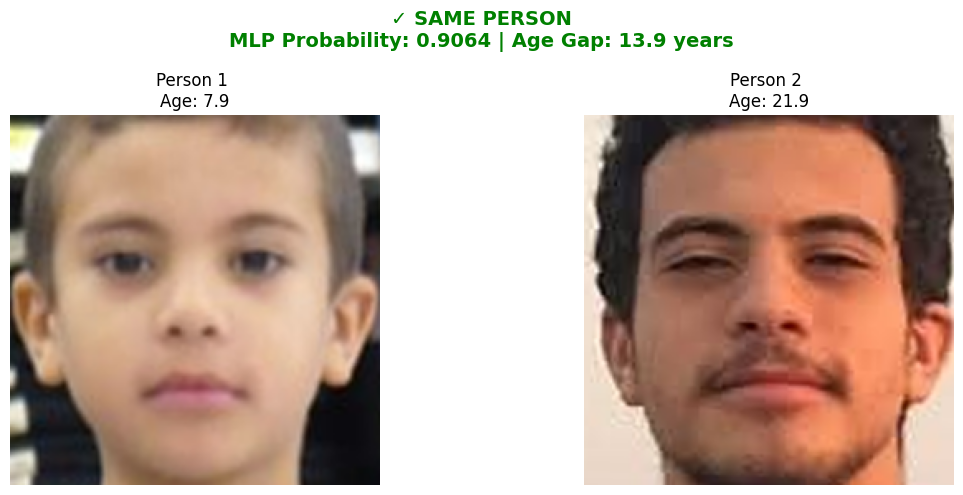


Image 1: Age 7.9
Image 2: Age 21.9
Age Difference: 13.9 years
MLP Probability: 0.9064
Threshold: 0.5
Result: SAME PERSON ✓


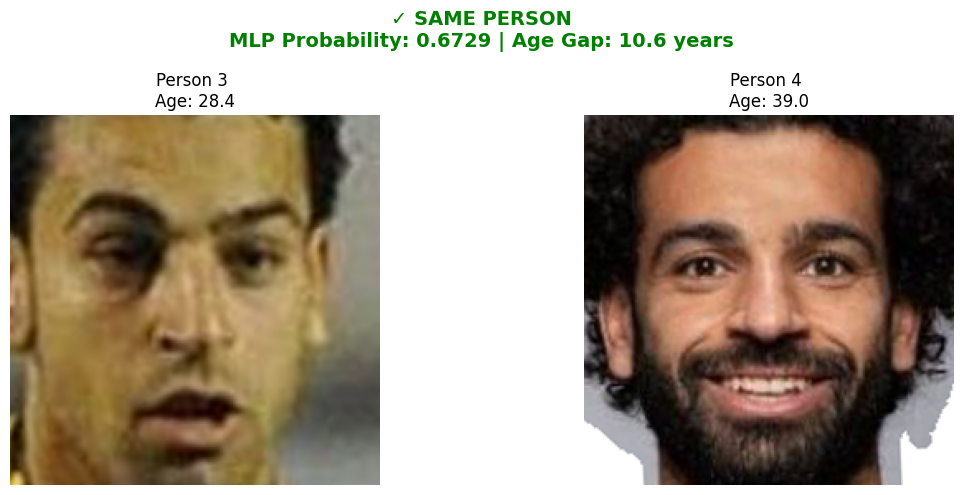


Image 1: Age 28.4
Image 2: Age 39.0
Age Difference: 10.6 years
MLP Probability: 0.6729
Threshold: 0.5
Result: SAME PERSON ✓


In [44]:
import gdown
import tensorflow as tf
from facenet_pytorch import MTCNN, InceptionResnetV1
from PIL import Image
import numpy as np
import cv2
from matplotlib import pyplot as plt
import torch

# -----------------------------
# 1. Load Models
# -----------------------------
# Age prediction model
file_id = "1xyGYBYRQwjBpPreZmvv_enQ3Z92wHNSx"
download_url = f"https://drive.google.com/uc?id={file_id}"
output_path = "resnet50_age_model.keras"
gdown.download(download_url, output_path, quiet=False)
age_model = tf.keras.models.load_model(output_path)

# Face detection
mtcnn = MTCNN()

# Face matching model
facenet = InceptionResnetV1(pretrained='vggface2').eval()

# Load MLP verification model
mlp_model = tf.keras.models.load_model('face_verification_mlp.keras')

print("✓ All models loaded!")

# -----------------------------
# 2. Helper Functions
# -----------------------------
def align_face(img_cv, landmark, output_size=(224, 224)):
    """Align face based on eye landmarks"""
    left_eye, right_eye, nose = landmark[0], landmark[1], landmark[2]

    eyes_center = ((left_eye[0] + right_eye[0]) / 2,
                   (left_eye[1] + right_eye[1]) / 2)

    dy, dx = right_eye[1] - left_eye[1], right_eye[0] - left_eye[0]
    angle = np.degrees(np.arctan2(dy, dx))

    desired_eye_distance = output_size[0] * 0.35
    dist = np.sqrt(dx**2 + dy**2)
    scale = desired_eye_distance / dist

    M = cv2.getRotationMatrix2D(eyes_center, angle, scale)
    M[0, 2] += (output_size[0] * 0.5 - eyes_center[0])
    M[1, 2] += (output_size[1] * 0.4 - eyes_center[1])

    aligned_face = cv2.warpAffine(img_cv, M, output_size, flags=cv2.INTER_CUBIC)
    return aligned_face

def preprocess_for_age(face_img):
    """Preprocess for age model (ResNet50)"""
    from tensorflow.keras.applications.resnet50 import preprocess_input
    x = cv2.cvtColor(face_img, cv2.COLOR_BGR2RGB)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

def preprocess_for_facenet(face_img):
    """Preprocess for FaceNet (160x160, normalized)"""
    face_resized = cv2.resize(face_img, (160, 160))
    face_rgb = cv2.cvtColor(face_resized, cv2.COLOR_BGR2RGB)
    face_normalized = (face_rgb - 127.5) / 128.0
    face_tensor = torch.FloatTensor(face_normalized).permute(2, 0, 1).unsqueeze(0)
    return face_tensor

# -----------------------------
# 3. Main Function with MLP
# -----------------------------
def match_faces_mlp(img_path1, img_path2, threshold=0.5):
    """
    Match two face images using MLP classifier

    Args:
        img_path1, img_path2: Paths to images
        threshold: Probability threshold (default 0.5)

    Returns:
        Dictionary with results
    """
    results = {}

    # Process Image 1
    img1 = Image.open(img_path1).convert('RGB')
    img1_cv = cv2.cvtColor(np.array(img1), cv2.COLOR_RGB2BGR)
    boxes1, probs1, landmarks1 = mtcnn.detect(img1, landmarks=True)

    if boxes1 is None:
        print(f"No face detected in {img_path1}")
        return None

    aligned_face1 = align_face(img1_cv, landmarks1[0], output_size=(224, 224))

    # Age prediction for Image 1
    age_input1 = preprocess_for_age(aligned_face1)
    age1 = age_model.predict(age_input1, verbose=0)[0][0]

    # Face embedding for Image 1
    face_tensor1 = preprocess_for_facenet(aligned_face1)
    with torch.no_grad():
        embedding1 = facenet(face_tensor1).numpy().flatten()

    # Process Image 2
    img2 = Image.open(img_path2).convert('RGB')
    img2_cv = cv2.cvtColor(np.array(img2), cv2.COLOR_RGB2BGR)
    boxes2, probs2, landmarks2 = mtcnn.detect(img2, landmarks=True)

    if boxes2 is None:
        print(f"No face detected in {img_path2}")
        return None

    aligned_face2 = align_face(img2_cv, landmarks2[0], output_size=(224, 224))

    # Age prediction for Image 2
    age_input2 = preprocess_for_age(aligned_face2)
    age2 = age_model.predict(age_input2, verbose=0)[0][0]

    # Face embedding for Image 2
    face_tensor2 = preprocess_for_facenet(aligned_face2)
    with torch.no_grad():
        embedding2 = facenet(face_tensor2).numpy().flatten()

    # Prepare MLP input (1539D vector)
    diff = np.abs(embedding1 - embedding2)
    age_gap = abs(age1 - age2)

    # Concatenate: [emb1, emb2, diff, age1, age2, age_gap]
    mlp_input = np.concatenate([
        embedding1,  # 512D
        embedding2,  # 512D
        diff,        # 512D
        [age1],      # 1D
        [age2],      # 1D
        [age_gap]    # 1D
    ]).reshape(1, -1)  # Shape: (1, 1539)

    # MLP prediction
    probability = mlp_model.predict(mlp_input, verbose=0)[0][0]
    is_match = probability >= threshold

    # Store results
    results = {
        'age1': float(age1),
        'age2': float(age2),
        'age_difference': float(age_gap),
        'probability': float(probability),
        'is_match': is_match,
        'threshold': threshold,
        'face1': aligned_face1,
        'face2': aligned_face2
    }

    return results

def visualize_results_mlp(results, img_name1, img_name2):
    """Display results"""
    if results is None:
        return

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Image 1
    axes[0].imshow(cv2.cvtColor(results['face1'], cv2.COLOR_BGR2RGB))
    axes[0].set_title(f"{img_name1}\nAge: {results['age1']:.1f}", fontsize=12)
    axes[0].axis('off')

    # Image 2
    axes[1].imshow(cv2.cvtColor(results['face2'], cv2.COLOR_BGR2RGB))
    axes[1].set_title(f"{img_name2}\nAge: {results['age2']:.1f}", fontsize=12)
    axes[1].axis('off')

    # Overall result
    match_text = "✓ SAME PERSON" if results['is_match'] else "✗ DIFFERENT PEOPLE"
    color = 'green' if results['is_match'] else 'red'

    fig.suptitle(
        f"{match_text}\n"
        f"MLP Probability: {results['probability']:.4f} | "
        f"Age Gap: {results['age_difference']:.1f} years",
        fontsize=14, fontweight='bold', color=color
    )

    plt.tight_layout()
    plt.show()

    # Print details
    print("\n" + "="*50)
    print(f"Image 1: Age {results['age1']:.1f}")
    print(f"Image 2: Age {results['age2']:.1f}")
    print(f"Age Difference: {results['age_difference']:.1f} years")
    print(f"MLP Probability: {results['probability']:.4f}")
    print(f"Threshold: {results['threshold']}")
    print(f"Result: {'SAME PERSON ✓' if results['is_match'] else 'DIFFERENT PEOPLE ✗'}")
    print("="*50)

# -----------------------------
# 4. Usage Example
# -----------------------------
img1_path = "/content/test_images/ahmed7years.jpeg"
img2_path = "/content/test_images/ahmedthanwya3ama.jpeg"
img3_path="/content/test_images/mosalah_Arabcontractor.jfif"
img4_path="/content/test_images/Mo-Salah-PNG-Photo.png"
results =match_faces_mlp(img1_path, img2_path, threshold=0.5)
visualize_results_mlp(results, "Person 1 ", "Person 2 ")
results_v2=match_faces_mlp(img3_path, img4_path, threshold=0.5)
visualize_results_mlp(results_v2, "Person 3 ", "Person 4 ")